In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound is the maximum value of the action that the environment can accept

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # Splicing states and actions
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [3]:
class DDPG:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # Initialize the target value network and set the same parameters as the value network
        self.target_critic.load_state_dict(self.critic.state_dict())
        # Initialize the target policy network and set the same parameters as the policy network
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # The standard deviation of Gaussian noise, the mean is directly set to 0
        self.tau = tau  # Target network soft_update parameter
        self.action_dim = action_dim
        self.device = device
        self.action_bound = action_bound


    def take_action(self, state):
        # Adding noise to the action increases exploration (Use self.sigma = sigma)
        state = torch.tensor(state, dtype=torch.float).to(self.device)

        action = self.actor(state).item()
        action = action + self.sigma * np.random.normal(0, 1, 1)
        action = np.clip(action, -self.action_bound, self.action_bound)
        return action


    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)


    def update(self, transition_dict):
        # Remember for target Network, Use soft_update
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # theta_target -> self.target_actor
        # theta        -> self.actor
        # phi_target   -> self.target_critic
        # phi          -> self.critic


        # compute targets
        # target: y = r + gamma * (1 - d) * Q_target
        Q_next = self.target_critic(next_states, self.target_actor(next_states))
        Q_target = rewards + self.gamma * (1 - dones) * Q_next

        # upload Q-function by one step of gradient descent
        loss_critic = nn.MSELoss()(self.critic(states, actions), Q_target.detach()).mean()
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        self.critic_optimizer.step()

        # upload policy by one step of gradient **ascent**
        loss_actor = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()

        # update target networks
        self.soft_update(self.critic, self.target_critic)
        self.soft_update(self.actor, self.target_actor)

In [4]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # Target network soft_update parameter
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # Gaussian noise standard deviation

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device=gpu would cause a strange decrease in the end of the plot??
# and this is a small experiment, cpu would be even faster
device =  torch.device("cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # Action Maximum
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)


torch.save(agent.actor.state_dict(), "ddpg_pendulum_actor.pth")
torch.save(agent.critic.state_dict(), "ddpg_pendulum_critic.pth")

/home/cellverse/mambaforge/envs/RL/lib/python3.10/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_2731455/4093390824.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
Iteration 9: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s, episode=200, return=-243.562]


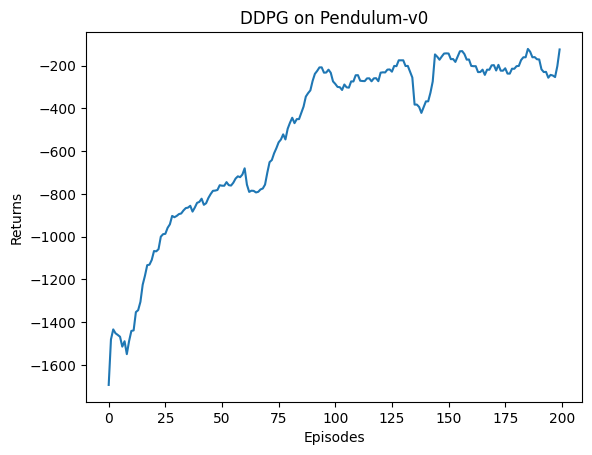

In [5]:
episodes_list = list(range(len(return_list)))

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()